# Bottlenecking

## 1. Setup and configuration

In [25]:
# Necessary imports
import numpy  as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy.misc import imresize
from keras import optimizers
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import ELU

In [26]:
%matplotlib inline

In [27]:
# Seed for reproducibility
np.random.seed(0)

In [28]:
# Local data paths
TRAIN_PATH = "../../../../data/wiki_folds/gender/train_1.csv"
VALID_PATH = "../../../../data/wiki_folds/gender/valid_1.csv"
IMG_PATH  = "../../../../data/wiki/%s"

In [29]:
# Image dimensions and num epochs
IMG_WIDTH  = 224
IMG_HEIGHT = 224
IMG_DIMS = (IMG_WIDTH,IMG_HEIGHT)

# VGG16-Face Pre-trained weights download links
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
VGG16_LOCAL_W   = "'vgg16_weights_tf_dim_ordering_tf_kernels.h5'"

In [30]:
# Experiment config
NUM_EPOCHS     = 1400
BATCH_SIZE     = 32
TARGET_FEATURE = "age"

## 2. Loading the data

In [31]:
# Read training and validation sets of this fold
train = pd.read_csv(TRAIN_PATH)
valid = pd.read_csv(VALID_PATH)

# Drop unecessary columns
train = train[["full_path","gender","age"]]
valid = valid[["full_path","gender","age"]]

In [32]:
# Setting data path to be relative to the current directory
true_path = lambda x: IMG_PATH % x
train["full_path"] = train["full_path"].apply(lambda x: true_path(x))
valid["full_path"] = valid["full_path"].apply(lambda x: true_path(x))

In [33]:
# Preview training set
train.head()

,full_path,gender,age
0,../../../../data/wiki/79/3781079_1888-02-15_19...,1.0,93
1,../../../../data/wiki/72/8801772_1950-11-09_20...,1.0,62
2,../../../../data/wiki/10/33256210_1979-04-06_2...,1.0,33
3,../../../../data/wiki/07/14853007_1984-05-07_2...,0.0,23
4,../../../../data/wiki/27/11914827_1986-05-21_2...,1.0,28


In [34]:
# Preview validation set
valid.head()

,full_path,gender,age
0,../../../../data/wiki/17/8740317_1961-08-29_20...,1.0,48
1,../../../../data/wiki/40/31819740_1984-10-18_2...,1.0,30
2,../../../../data/wiki/81/32702381_1929-02-17_1...,1.0,27
3,../../../../data/wiki/69/43906569_1930-04-24_1...,1.0,22
4,../../../../data/wiki/69/16116069_1942-04-20_2...,0.0,69


## 3. Declaring the network

In [35]:
# VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(IMG_WIDTH, IMG_HEIGHT,3)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

In [36]:
model.add(Flatten())
model.add(Dense(4096, activation='relu', name="fc_1"))
model.add(Dense(4096, activation='relu', name="fc_w"))
model.add(Dense(1000, activation='softmax',  name="predictions"))

In [37]:
# Obtain VGG16-Face weights
weights_path = get_file(VGG16_LOCAL_W,TF_WEIGHTS_PATH, cache_subdir='models')

In [38]:
# Loading VGG16-Face weights to VGG16 network
model.load_weights(weights_path)

In [39]:
model.layers.pop()
model.add(Dense(500,activation=ELU(alpha=1.0)))
model.add(Dense(100,activation=ELU(alpha=1.0)))
model.add(Dense(1,activation=ELU(alpha=1.0)))

In [40]:
# Compile
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=['mse'])

## 4. Setting up the training pipeline

In [41]:
# Handy utility to read the image raw data from its ath
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

In [42]:
# Data generator
def generate_data(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        data   = df.sample(frac=1).reset_index(drop=True)
        sample = data[start:end]
        
        X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
        good_rows = X["full_path"] != "ERR"
        X         = X[good_rows]
        X.reset_index(inplace=True)
        X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        #X = model.predict(X, X.shape[0])
        
        Y = sample[good_rows]
        Y = Y[target_feature].as_matrix()
        yield (X,Y)

In [43]:
train_gen = generate_data(train, BATCH_SIZE, TARGET_FEATURE)
valid_gen = generate_data(valid, BATCH_SIZE, TARGET_FEATURE)

In [44]:
X,Y = train_gen.next()

In [45]:
X.shape

(32, 224, 224, 3)

In [46]:
Y.shape

(32,)

In [47]:
for layer in model.layers[:len(model.layers)-7]:
    layer.trainable = False

In [48]:
# Train
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS)

Epoch 1/1400
32/32 [==============================] - 4s - loss: 1583.3737 - mean_squared_error: 1583.3737 - val_loss: 1420.7468 - val_mean_squared_error: 1420.7468
Epoch 2/1400
32/32 [==============================] - 2s - loss: 1778.9751 - mean_squared_error: 1778.9751 - val_loss: 1577.0801 - val_mean_squared_error: 1577.0801
Epoch 3/1400
32/32 [==============================] - 2s - loss: 2021.6154 - mean_squared_error: 2021.6154 - val_loss: 2097.1997 - val_mean_squared_error: 2097.1997
Epoch 4/1400
32/32 [==============================] - 2s - loss: 1519.6636 - mean_squared_error: 1519.6636 - val_loss: 1835.4095 - val_mean_squared_error: 1835.4095
Epoch 5/1400
32/32 [==============================] - 2s - loss: 1618.5188 - mean_squared_error: 1618.5188 - val_loss: 1734.0640 - val_mean_squared_error: 1734.0640
Epoch 6/1400
32/32 [==============================] - 2s - loss: 1902.5327 - mean_squared_error: 1902.5327 - val_loss: 1331.6003 - val_mean_squared_error: 1331.6003
Epoch 7/14

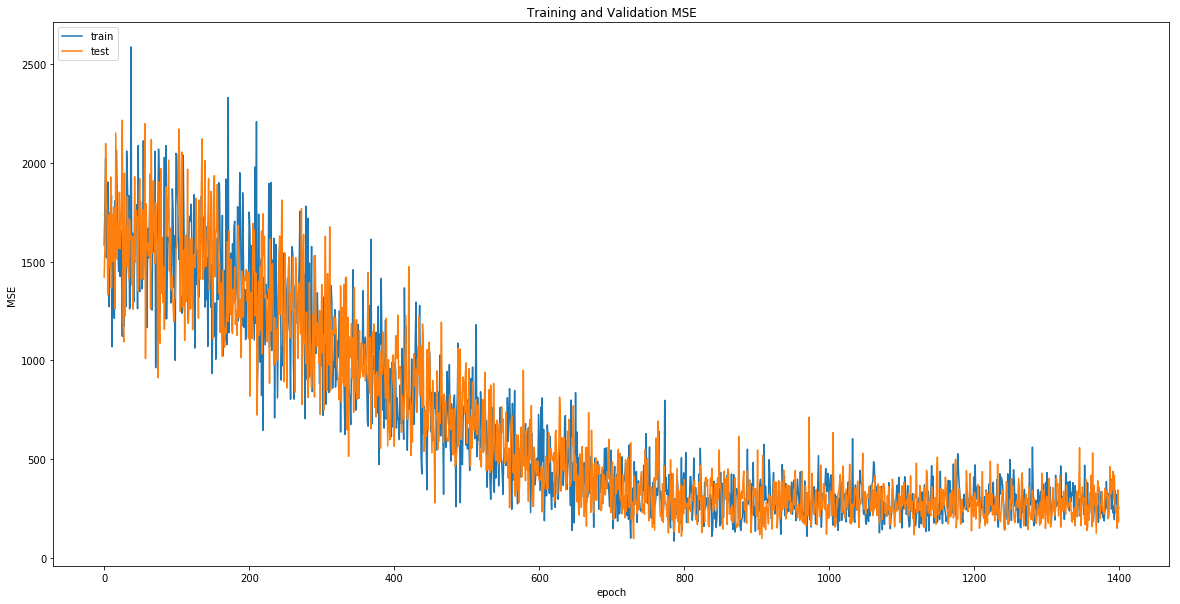

In [49]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Training and Validation MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model_vgg16_elu_fold1.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_vgg16_elu_fold1_7layers_slow.h5")
print("Saved model to disk")

Saved model to disk


In [52]:
#Binary data
np.save("history_vgg16_elu_fold1_7layers_slow.npy", history.history["mean_squared_error"])
np.savetxt("history_vgg16_elu_fold1_7layers_slow.txt", history.history["val_mean_squared_error"])


In [55]:
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.0000005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4), metrics=['mse'])

In [58]:
# Train
history2 = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS*7)

Epoch 1/9800
32/32 [==============================] - 1s - loss: 241.4104 - mean_squared_error: 241.4104 - val_loss: 218.7925 - val_mean_squared_error: 218.7925
Epoch 2/9800
32/32 [==============================] - 1s - loss: 216.7462 - mean_squared_error: 216.7462 - val_loss: 223.7132 - val_mean_squared_error: 223.7132
Epoch 3/9800
32/32 [==============================] - 1s - loss: 275.5843 - mean_squared_error: 275.5843 - val_loss: 341.3893 - val_mean_squared_error: 341.3893
Epoch 4/9800
32/32 [==============================] - 1s - loss: 183.4987 - mean_squared_error: 183.4987 - val_loss: 246.2607 - val_mean_squared_error: 246.2607
Epoch 5/9800
32/32 [==============================] - 1s - loss: 270.7230 - mean_squared_error: 270.7230 - val_loss: 385.6558 - val_mean_squared_error: 385.6558
Epoch 6/9800
32/32 [==============================] - 1s - loss: 427.0275 - mean_squared_error: 427.0275 - val_loss: 418.9402 - val_mean_squared_error: 418.9402
Epoch 7/9800
32/32 [==============